In [31]:
%matplotlib inline

import os
import sys

sys.path.append('../global_search/')
sys.path.append('../../txf_design_space/embeddings')

from utils import embedding_util

from utils import graph_util, print_util as pu

import yaml
import collections
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE as tsne
from scipy.spatial.distance import pdist
from skopt.sampler import Sobol, Lhs, Halton, Hammersly, Grid

In [2]:
# Load design space
design_space = yaml.safe_load(open('../global_search/design_space/design_space.yaml'))

In [3]:
# Check basic conversion to 
bert_mini_model_dict = {"l": 4, "o": 
                        [["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64", "sa_sdp_64", "sa_sdp_64"]], 
                        "h": [256, 256, 256, 256], "f": [[1024], [1024], [1024], [1024]]}

bert_mini_embedding = embedding_util.model_dict_to_embedding(bert_mini_model_dict, design_space)

print(f'BERT-Mini\'s embedding: {bert_mini_embedding}')

model_dict = embedding_util.embedding_to_model_dict(bert_mini_embedding, design_space)

print(f'BERT-Mini\'s model dictionary: {model_dict}')

BERT-Mini's embedding: [1, 1, 2, 28, 1, 2, 28, 1, 2, 28, 1, 2, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
BERT-Mini's model dictionary: {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']], 'h': [256, 256, 256, 256], 'f': [[1024], [1024], [1024], [1024]]}


In [4]:
# Check if BERT-Mini's embedding is valid
embedding_util.is_valid_embedding(bert_mini_embedding, design_space)

True

In [25]:
# Get sampler function

def get_samples(num_samples: int, sampler='Sobol'):
    # sampler should be in 'Sobol', 'Lhs', 'Halton' or 'Hammersly'
    
    print(f'Generating {num_samples} samples using the {sampler} sampler...')
    
    if sampler == 'Lhs':
        exec(f'narrow_sampler = {sampler}(criterion="ratio")')
        exec(f'wide_sampler = {sampler}(criterion="ratio")')
    else:
        exec(f'narrow_sampler = {sampler}()')
        exec(f'wide_sampler = {sampler}()')
    
    narrow_embedding_bounds = embedding_util.get_embedding_bounds(design_space, type='narrow')
    wide_embedding_bounds = embedding_util.get_embedding_bounds(design_space, type='wide')

    narrow_sampled_embeddings = \
        eval(f'narrow_sampler.generate(narrow_embedding_bounds, {num_samples}, random_state=0)')
    wide_sampled_embeddings = \
        eval(f'wide_sampler.generate(wide_embedding_bounds, {num_samples}, random_state=0)')

    narrow_valid_embeddings = \
        [embedding_util.get_nearest_valid_embedding(embedding, design_space) for embedding in narrow_sampled_embeddings]
    wide_valid_embeddings = \
        [embedding_util.get_nearest_valid_embedding(embedding, design_space) for embedding in wide_sampled_embeddings]

    narrow_model_dicts = \
        [embedding_util.embedding_to_model_dict(embedding, design_space) for embedding in narrow_valid_embeddings]
    wide_model_dicts = \
        [embedding_util.embedding_to_model_dict(embedding, design_space) for embedding in wide_valid_embeddings]

    narrow_model_types = [embedding_util.get_model_type(model_dict, design_space) for model_dict in narrow_model_dicts]
    wide_model_types = [embedding_util.get_model_type(model_dict, design_space) for model_dict in wide_model_dicts]

    print(f'Narrow model types: {collections.Counter(narrow_model_types)}')
    print(f'Wide model types: {collections.Counter(wide_model_types)}')

    all_model_dicts = narrow_model_dicts + wide_model_dicts
    all_hashes = []

    for model_dict in all_model_dicts:
        model_graph = graph_util.model_dict_to_graph(model_dict)
        model_hash = graph_util.hash_graph(*model_graph, model_dict=model_dict)
        all_hashes.append(model_hash)

    assert len(set(all_hashes)) == len(all_model_dicts) 
    
    all_embeddings = narrow_valid_embeddings + wide_valid_embeddings
    
    return all_embeddings

Generating 128 samples using the Sobol sampler...
Narrow model types: Counter({'deep_narrow': 64, 'shallow_narrow': 64})
Wide model types: Counter({'deep_wide': 64, 'shallow_wide': 64})


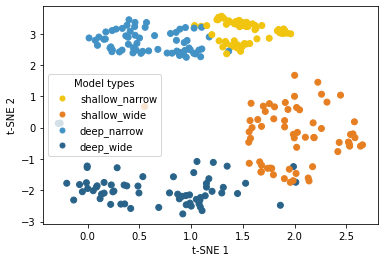

Generating 128 samples using the Lhs sampler...
Narrow model types: Counter({'deep_narrow': 64, 'shallow_narrow': 64})
Wide model types: Counter({'deep_wide': 64, 'shallow_wide': 64})


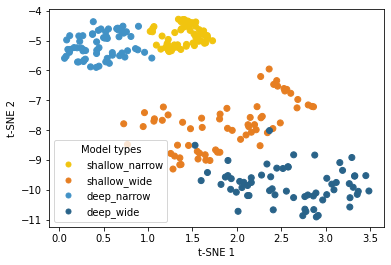

Generating 128 samples using the Halton sampler...
Narrow model types: Counter({'shallow_narrow': 65, 'deep_narrow': 63})
Wide model types: Counter({'shallow_wide': 65, 'deep_wide': 63})


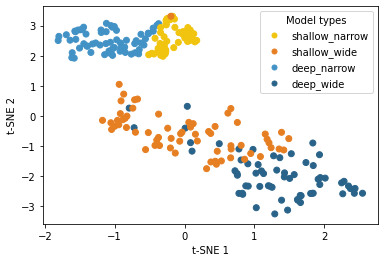

Generating 128 samples using the Hammersly sampler...
Narrow model types: Counter({'shallow_narrow': 65, 'deep_narrow': 63})
Wide model types: Counter({'shallow_wide': 65, 'deep_wide': 63})


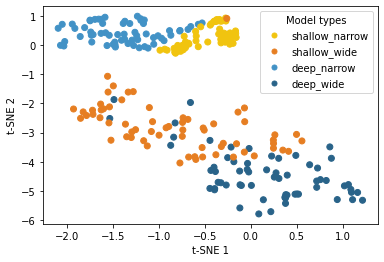

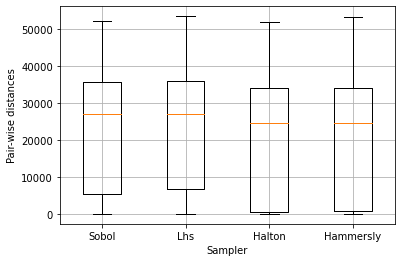

In [33]:
# Plot embeddings
model_type_to_color = {'shallow_narrow': '#F1C40F', 
                       'shallow_wide': '#E67E22', 
                       'deep_narrow': '#4292C6',
                       'deep_wide': '#296389'}

pdists = {'Sobol': [], 'Lhs': [], 'Halton': [], 'Hammersly': []}

for sampler in pdists.keys():
    all_embeddings = get_samples(num_samples=128, sampler=sampler)
    
    pdists[sampler] = pdist(all_embeddings).flatten()

    colors = []
    for embedding in all_embeddings:
        model_dict = embedding_util.embedding_to_model_dict(embedding, design_space)
        model_type = embedding_util.get_model_type(model_dict, design_space)
        colors.append(model_type_to_color[model_type])

    embeddings_2d = tsne(n_components=2, 
                         learning_rate='auto', 
                         perplexity=122,
                         early_exaggeration=1,
                         init='random', 
                         random_state=3).fit_transform(np.array(all_embeddings))

    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

    custom = [Line2D([], [], marker='.', markersize=10, color=color, linestyle='None') 
              for color in model_type_to_color.values()]
    plt.legend(custom, model_type_to_color.keys(), title='Model types')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()
    
plt.boxplot(pdists.values())
plt.xticks(ticks=np.arange(1, len(pdists)+1), labels=pdists.keys())
plt.xlabel('Sampler')
plt.ylabel('Pair-wise distances')
plt.grid()